In [2]:
import pandas as pd
import re
from nltk.corpus import stopwords

# Preprocess the synopsis text: remove punctuation, lowercase, and remove stopwords
# Ensure stopwords are downloaded
import nltk
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package stopwords to /Users/panda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load Datasets

df = pd.read_csv('friends_transcript_synopsis.csv')
df

,season,episode,transcript,season_episode,episode_title,synopsis
0,1,1,There's nothing to tell! He's just some guy I...,101,The One Where Monica Gets A New Roommate,Rachel leaves Barry at the alter and moves in ...
1,1,2,"What you guys don't understand is, for us, ki...",102,The One With the Sonogram at the End,Ross finds out his ex-wife (Carol) is pregnant...
2,1,3,"Hi guys! Hey, Pheebs! Hi! Hey. Oh, oh, h...",103,The One With the Thumb,"Ross discovers the fate of his childhood pet, ..."
3,1,4,"Alright. Phoebe? Okay, okay. If I were omni...",104,The One With George Stephanopoulos,"Ross, upset about it being the anniversary of ..."
4,1,5,Would you let it go? It's not that big a deal...,105,The One With The East-German Laundry Detergent,Chandler and Phoebe decide to break up with Ja...
...,...,...,...,...,...,...
222,10,13,Robert Carlock & Wendy Knoller Hi All: Hey!...,1013,The One Where Joey Speaks French,Joey is auditioning for a play and need to spe...
223,10,14,Friends - 10.14 - The One With Princess Con...,1014,The One With Princess Consuela,Rachel's lunch interview with Gucci turns out ...
224,10,15,Robert Carlock & Wendy Knoller Transcribed ...,1015,The One Where Estelle Dies,Ross visits Rachel's old boss at Ralph Lauren ...
225,10,16,"All right, all right, all right, let's play o...",1016,The One With Rachel's Going Away Party,Rachel finishes preparations to go to Paris. ...


# List of character names to exclude
character_names = ["joey", "rachel", "monica", "chandler", "phoebe", "ross"]


# Combine character names with English stop words
stop_words = set(stopwords.words('english')).union(character_names, ["said", "one", "would", "could"])
lemmatizer = WordNetLemmatizer()

In [5]:
# Combine character names with English stop words
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [6]:
def preprocess_text(text):
    # Tokenize, remove stop words, and lemmatize
    words = [lemmatizer.lemmatize(word) for word in text.lower().split() if word.isalpha() and word not in stop_words]
    return ' '.join(words)

# Apply preprocessing to the synopsis column
df['cleaned_synopsis'] = df['synopsis'].apply(preprocess_text)
df['cleaned_transcript'] = df['transcript'].apply(preprocess_text)

# Show the cleaned text
df[['synopsis', 'cleaned_synopsis']].head()
df[['transcript', 'cleaned_transcript']].head()

,transcript,cleaned_transcript
0,There's nothing to tell! He's just some guy I...,nothing guy work going gotta something wrong r...
1,"What you guys don't understand is, for us, ki...",guy understand kissing important part everythi...
2,"Hi guys! Hey, Pheebs! Hi! Hey. Oh, oh, h...",hi walked subway said said loosely translated ...
3,"Alright. Phoebe? Okay, okay. If I were omni...",omnipotent would world good thing bigger took ...
4,Would you let it go? It's not that big a deal...,would let big big reach one little bra right f...


In [7]:
# --------------------- #
#     using TF-IDF
# --------------------- #

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.85, min_df=1, ngram_range=(2, 2))
dtm = vectorizer.fit_transform(df[df['season'] == 1]['cleaned_synopsis'])

In [34]:
# print("TF-IDF Matrix Shape:", dtm.shape)
# print("Sample Features (terms):", vectorizer.get_feature_names_out()[:10])

In [8]:
# Step 2: Apply LDA
num_topics = 5
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=42)

In [10]:
# Step 3: Display the top words for each topic
def display_topics(model, feature_names, num_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        # Get top words and their TF-IDF weights
        top_words = [(feature_names[i], topic[i]) for i in topic.argsort()[-num_top_words:][::-1]]
        
        # Format as 'word (weight)' for easier readability
        topics[f"Topic {topic_idx + 1}"] = [f"{word} ({weight:.4f})" for word, weight in top_words]
        
    return pd.DataFrame(topics)

# Display the topics with top words
num_top_words = 15
topics_df = display_topics(lda_model, vectorizer.get_feature_names_out(), num_top_words)

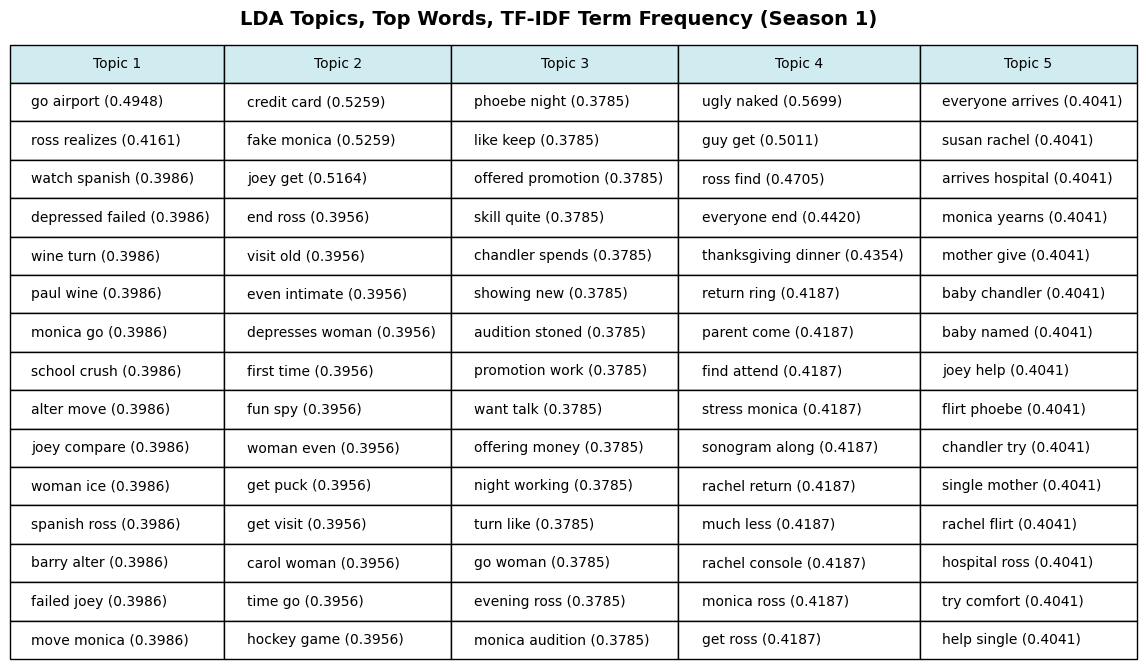

In [11]:
# --------------------- #
# display at a table 
# --------------------- #

import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust size as needed

# Adjust the top padding of the figure to make space for the title
plt.subplots_adjust(top=0.75)

# Hide axes
ax.axis('tight')
ax.axis('off')

# Create a table plot

table = ax.table(cellText=topics_df.values, colLabels=topics_df.columns, loc='center', cellLoc='left', colColours=['#d1ecf1'] * topics_df.shape[1])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(topics_df.columns))))

for i in range(len(topics_df) + 1):  # +1 to include header row
    for j in range(len(topics_df.columns)):
        table[i, j].set_height(0.10)


# Title
fig.suptitle("LDA Topics, Top Words, TF-IDF Term Frequency (Season 1)", fontsize=14, fontweight="bold", ha='center', y=1)

# Display the plot
plt.savefig("season1-tfidf.png", dpi=300)
plt.show()

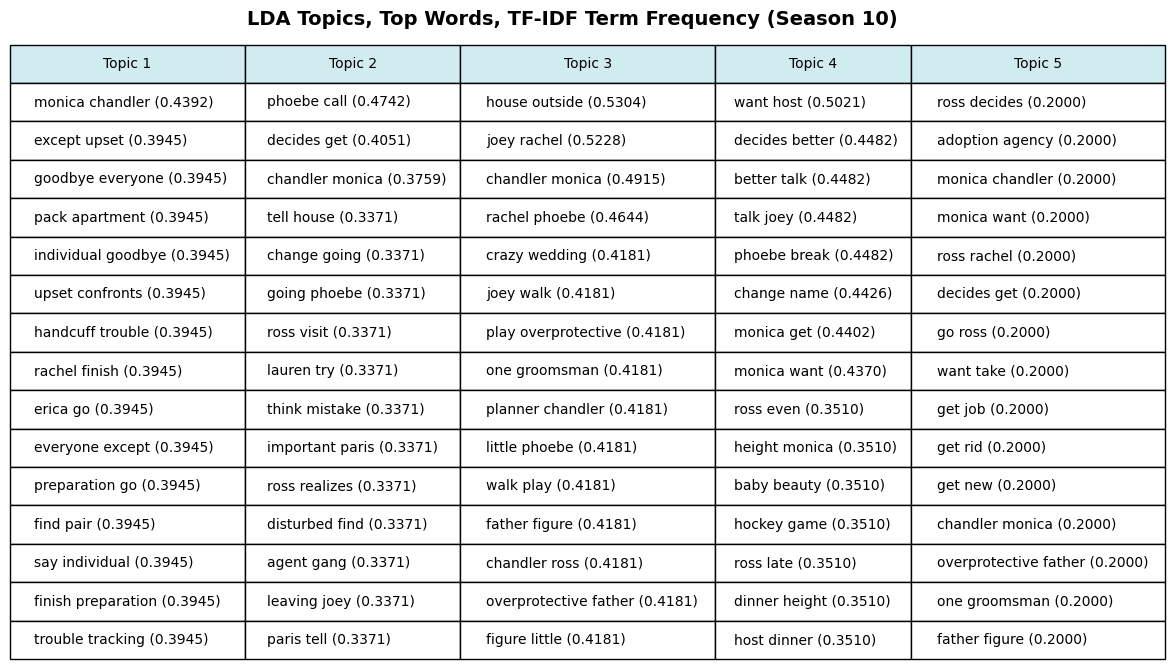

In [12]:
# Season 10

dtm_10 = vectorizer.fit_transform(df[df['season'] == 10]['cleaned_synopsis'])

lda_model_10 = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model_10.fit(dtm_10)

# Display the top words for each topic
def display_topics(model, feature_names, num_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        # Get top words and their TF-IDF weights
        top_words = [(feature_names[i], topic[i]) for i in topic.argsort()[-num_top_words:][::-1]]
        
        # Format as 'word (weight)' for easier readability
        topics[f"Topic {topic_idx + 1}"] = [f"{word} ({weight:.4f})" for word, weight in top_words]
        
    return pd.DataFrame(topics)

# Display the topics with top words
num_top_words = 15
topics_df_10 = display_topics(lda_model_10, vectorizer.get_feature_names_out(), num_top_words)

# --------------------- #
# display at a table 
# --------------------- #


# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust size as needed

# Adjust the top padding of the figure to make space for the title
plt.subplots_adjust(top=0.75)

# Hide axes
ax.axis('tight')
ax.axis('off')

# Create a table plot

table = ax.table(cellText=topics_df_10.values, colLabels=topics_df_10.columns, loc='center', cellLoc='left', colColours=['#d1ecf1'] * topics_df_10.shape[1])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(topics_df_10.columns))))

for i in range(len(topics_df_10) + 1):  # +1 to include header row
    for j in range(len(topics_df_10.columns)):
        table[i, j].set_height(0.10)


# Title
fig.suptitle("LDA Topics, Top Words, TF-IDF Term Frequency (Season 10)", fontsize=14, fontweight="bold", ha='center', y=1)

# Display the plot
plt.savefig("season10-tfidf.png", dpi=300)
plt.show()
